In [1]:
import numpy as np
import time 
import matplotlib.pyplot as plt
from util import *

%load_ext autoreload
%autoreload 2

In [2]:
MicroArray,Labels = read_data(mode="CellType",th=20)
MicroArray = pca(MicroArray,0.95)
print MicroArray.shape

Loading Previous Data!
883
(1077, 883)


In [3]:
class_num = len(np.unique(Labels))
input_dim = MicroArray.shape[1]
print class_num,input_dim

19 883


In [4]:
## shuffle data and divide it into 5 parts
from util import *

MicroLabels = Labels
MicroArray_train,MicroLabels_train,MicroArray_test,MicroLabels_test = division(MicroArray,MicroLabels)

print MicroArray_train.shape
print MicroArray_test.shape
print MicroLabels_train.shape
print MicroLabels_test.shape

(869, 883)
(208, 883)
(869, 1)
(208, 1)


4 235.0
11 16.0
45.7368421053


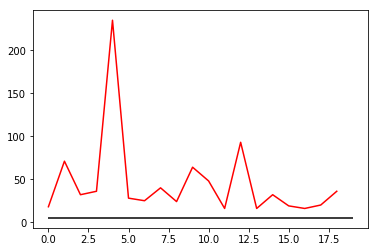

In [5]:
import matplotlib.pyplot as plt
uniq = np.unique(MicroLabels_train)
distribution = np.zeros(len(uniq))

for i in range(len(MicroLabels_train)):
    distribution[int(MicroLabels_train[i])] += 1
    
print np.argmax(distribution),np.max(distribution)
print np.argmax(-distribution),np.min(distribution)
print np.mean(distribution)
#plt.ylim(0,100)
plt.hlines(5,0,len(uniq))

plt.plot(distribution,"r")
plt.show()

4 58.0
0 4.0
10.9473684211


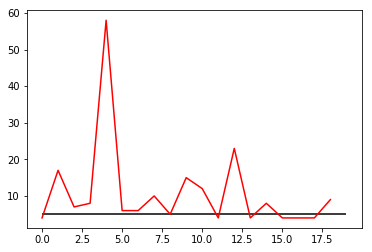

In [6]:
import matplotlib.pyplot as plt
uniq = np.unique(MicroLabels_test)
distribution = np.zeros(len(uniq))

for i in range(len(MicroLabels_test)):
    distribution[int(MicroLabels_test[i])] += 1
    
print np.argmax(distribution),np.max(distribution)
print np.argmax(-distribution),np.min(distribution)
print np.mean(distribution)
#plt.ylim(0,100)
plt.hlines(5,0,len(uniq))

plt.plot(distribution,"r")
plt.show()

# use tensorflow 

In [7]:
import tensorflow as tf

def save_model(name):
    saver = tf.train.Saver()
    path = "./models/%s.ckpt" % name
    save_path = saver.save(sess,path)
    print("Model saved in file: %s" % save_path)
    
def load_model(name):
    saver = tf.train.Saver()
    path = "./models/%s.ckpt" % name
    saver.restore(sess, path)
    print("Model restored.")

In [8]:
# creating nodes for the input images and target output classes.
sess = tf.InteractiveSession()
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')
x = tf.placeholder(tf.float32, shape=[None, input_dim])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [9]:
reg_penalty = 1e-2

W1 = tf.Variable(
    tf.random_normal(shape = [input_dim,2000],mean=0.01,stddev=0.1),name = "W1"
)
b1 = tf.Variable(
    tf.random_normal(shape = [2000],mean=0.01,stddev=0.1),name = "b1"
)
n1 = reg_penalty * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(b1)))
y1 = tf.matmul(x,W1) + b1
#o1 = tf.sigmoid(y1)
o1 = tf.nn.relu(y1)

W2 = tf.Variable(
    tf.random_normal(shape = [2000,1000],mean=0.01,stddev=0.1),name = "W2"
)
b2 = tf.Variable(
    tf.random_normal(shape = [1000],mean=0.01,stddev=0.1),name = "b2"
)
n2 = reg_penalty * (tf.reduce_sum(tf.square(W2)) + tf.reduce_sum(tf.square(b2)))
y2 = tf.matmul(o1,W2) + b2
#o2 = tf.sigmoid(y2)
o2 = tf.nn.relu(y2)

W3 = tf.Variable(
    tf.random_normal(shape = [1000,500],mean=0.01,stddev=0.1),name = "W3"
)
b3 = tf.Variable(
    tf.random_normal(shape = [500],mean=0.01,stddev=0.1),name = "b3"
)
n3 = reg_penalty * (tf.reduce_sum(tf.square(W3)) + tf.reduce_sum(tf.square(b3)))
y3 = tf.matmul(o2,W3) + b3
#o3 = tf.sigmoid(y3)
o3 = tf.nn.relu(y3)

W4 = tf.Variable(
    tf.random_normal(shape = [500,class_num],mean=0.01,stddev=0.1),name = "W4"
)
b4 = tf.Variable(
    tf.random_normal(shape = [class_num],mean=0.01,stddev=0.1),name = "b4"
)
n4 = reg_penalty * (tf.reduce_sum(tf.square(W4)) + tf.reduce_sum(tf.square(b4)))
y4 = tf.matmul(o3,W4) + b4

onehot_labels = tf.one_hot(indices=tf.cast(y_, tf.int32), depth = class_num)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=onehot_labels, logits=y4))

#loss = cross_entropy
loss = cross_entropy + n1 + n2 + n3 + n4

In [10]:
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step_tensor,
                                       10000, 0.96, staircase=True)

opt = tf.train.AdamOptimizer(
    learning_rate = learning_rate,
    beta1 = 0.9,
    beta2 = 0.999,
    epsilon = 1e-08,
    use_locking = False,
    name='Adam'
)

train_step = opt.minimize(
    loss, global_step = global_step_tensor)

In [11]:
#load_model("pca+l2")
tf.global_variables_initializer().run()

In [14]:
def eval_accuracy(data,labels):
    prediction = tf.identity(y4).eval(feed_dict={x: data})
    prediction = np.argmax(prediction,axis=1).reshape([-1,1])
    return np.mean(prediction == labels)

def predict(data):
    prediction = tf.identity(y4).eval(feed_dict={x: data})
    prediction = np.argmax(prediction,axis=1)
    return prediction
    
def eval_mse_loss(data,labels):
    entropy = tf.identity(cross_entropy).eval(feed_dict={x: data, y_: labels})
    return entropy

def eval_loss(data,labels):
    l = tf.identity(loss).eval(feed_dict={x: data, y_: labels})
    return l

def valid_batch(batch,th=0.2):
    uni = np.unique(batch)
    for i in uni:
        if(np.sum(batch==i) > th*batch.shape[0]):
            return False
    return True

In [13]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [23]:
batch_size = 20
epoch = int( MicroArray_train.shape[0] / batch_size)
print epoch
epoch_iter = 1000
max_test = 0

for step in range(epoch_iter * epoch):
  random = np.random.choice(MicroArray_train.shape[0],batch_size,replace=False)
#   while(not valid_batch(Labels[random])):
#         random = np.random.choice(MicroArray_train.shape[0],batch_size,replace=False)
  feed_dict = {x: MicroArray_train[random,:], y_: MicroLabels_train[random]}
  _,a = sess.run([train_step,loss],feed_dict=feed_dict)
  b = eval_loss(MicroArray_test,MicroLabels_test)  
  if(step % epoch == 0):
      train_loss.append(a)
      test_loss.append(b)
      train_accuracy = eval_accuracy(MicroArray_train,MicroLabels_train)
      test_accuracy = eval_accuracy(MicroArray_test,MicroLabels_test)
      train_acc.append(train_accuracy)
      test_acc.append(test_accuracy)
      if(test_accuracy>max_test):
        max_test = test_accuracy
        save_model("pca+l2+1e-2")
      print "epoch:%d   train loss:%f ,test loss :%f,train accuracy:%f,test accuracy:%f" % \
        (step/epoch,a,b,train_accuracy,test_accuracy)

43
Model saved in file: ./models/pca+l2+1e-2.ckpt
epoch:0   train loss:25.246691 ,test loss :57.134338,train accuracy:0.950518,test accuracy:0.812500
Model saved in file: ./models/pca+l2+1e-2.ckpt
epoch:1   train loss:24.544777 ,test loss :50.143867,train accuracy:0.960875,test accuracy:0.855769
Model saved in file: ./models/pca+l2+1e-2.ckpt
epoch:2   train loss:23.545923 ,test loss :48.282825,train accuracy:0.956272,test accuracy:0.865385
epoch:3   train loss:22.459137 ,test loss :45.329456,train accuracy:0.965478,test accuracy:0.855769
epoch:4   train loss:21.858025 ,test loss :41.760948,train accuracy:0.952819,test accuracy:0.836538
epoch:5   train loss:20.786409 ,test loss :45.786083,train accuracy:0.968930,test accuracy:0.826923
epoch:6   train loss:19.990614 ,test loss :40.144550,train accuracy:0.966628,test accuracy:0.850962
epoch:7   train loss:19.182890 ,test loss :38.217697,train accuracy:0.967779,test accuracy:0.846154
epoch:8   train loss:18.405918 ,test loss :36.748367,tra

epoch:81   train loss:1.061770 ,test loss :1.279409,train accuracy:0.963176,test accuracy:0.879808
epoch:82   train loss:1.065765 ,test loss :1.265258,train accuracy:0.962025,test accuracy:0.865385
epoch:83   train loss:0.971631 ,test loss :1.183535,train accuracy:0.963176,test accuracy:0.865385
epoch:84   train loss:0.896223 ,test loss :1.149401,train accuracy:0.963176,test accuracy:0.884615
epoch:85   train loss:1.053408 ,test loss :1.267814,train accuracy:0.960875,test accuracy:0.884615
epoch:86   train loss:0.875117 ,test loss :1.233706,train accuracy:0.958573,test accuracy:0.855769
epoch:87   train loss:0.918356 ,test loss :1.149559,train accuracy:0.963176,test accuracy:0.860577
epoch:88   train loss:0.857667 ,test loss :1.077113,train accuracy:0.967779,test accuracy:0.870192
epoch:89   train loss:0.818300 ,test loss :1.094884,train accuracy:0.964327,test accuracy:0.870192
Model saved in file: ./models/pca+l2+1e-2.ckpt
epoch:90   train loss:0.850564 ,test loss :0.998955,train accu

epoch:162   train loss:0.451383 ,test loss :0.691209,train accuracy:0.967779,test accuracy:0.836538
epoch:163   train loss:0.316477 ,test loss :0.583349,train accuracy:0.965478,test accuracy:0.879808
epoch:164   train loss:0.365425 ,test loss :0.549188,train accuracy:0.966628,test accuracy:0.899038
epoch:165   train loss:0.831653 ,test loss :0.758440,train accuracy:0.968930,test accuracy:0.846154
epoch:166   train loss:0.369911 ,test loss :0.559867,train accuracy:0.965478,test accuracy:0.850962
epoch:167   train loss:0.320314 ,test loss :0.631796,train accuracy:0.966628,test accuracy:0.836538
epoch:168   train loss:0.398478 ,test loss :0.634650,train accuracy:0.966628,test accuracy:0.841346
epoch:169   train loss:0.283340 ,test loss :0.640663,train accuracy:0.970081,test accuracy:0.836538
epoch:170   train loss:0.443637 ,test loss :0.568101,train accuracy:0.964327,test accuracy:0.836538
epoch:171   train loss:0.338846 ,test loss :0.601059,train accuracy:0.968930,test accuracy:0.860577


epoch:244   train loss:0.196907 ,test loss :0.516771,train accuracy:0.970081,test accuracy:0.846154
epoch:245   train loss:0.258601 ,test loss :0.500265,train accuracy:0.967779,test accuracy:0.879808
epoch:246   train loss:0.227813 ,test loss :0.521044,train accuracy:0.967779,test accuracy:0.850962
epoch:247   train loss:0.299391 ,test loss :0.490687,train accuracy:0.972382,test accuracy:0.865385
epoch:248   train loss:0.248816 ,test loss :0.496625,train accuracy:0.968930,test accuracy:0.865385
epoch:249   train loss:0.353562 ,test loss :0.546403,train accuracy:0.968930,test accuracy:0.846154
epoch:250   train loss:0.321232 ,test loss :0.633627,train accuracy:0.968930,test accuracy:0.841346
epoch:251   train loss:0.251535 ,test loss :0.511400,train accuracy:0.964327,test accuracy:0.870192
epoch:252   train loss:0.349110 ,test loss :0.559360,train accuracy:0.966628,test accuracy:0.850962
epoch:253   train loss:0.282763 ,test loss :0.532411,train accuracy:0.967779,test accuracy:0.879808


epoch:326   train loss:0.322339 ,test loss :0.600359,train accuracy:0.964327,test accuracy:0.850962
epoch:327   train loss:0.236678 ,test loss :0.538109,train accuracy:0.966628,test accuracy:0.860577
epoch:328   train loss:0.214370 ,test loss :0.493195,train accuracy:0.967779,test accuracy:0.875000
epoch:329   train loss:0.269374 ,test loss :0.500239,train accuracy:0.971231,test accuracy:0.850962
epoch:330   train loss:0.195042 ,test loss :0.481044,train accuracy:0.970081,test accuracy:0.865385
epoch:331   train loss:0.220809 ,test loss :0.461173,train accuracy:0.970081,test accuracy:0.865385
epoch:332   train loss:0.207723 ,test loss :0.512693,train accuracy:0.968930,test accuracy:0.846154
epoch:333   train loss:0.196776 ,test loss :0.462989,train accuracy:0.970081,test accuracy:0.879808
epoch:334   train loss:0.206786 ,test loss :0.497225,train accuracy:0.970081,test accuracy:0.865385
epoch:335   train loss:0.185106 ,test loss :0.458653,train accuracy:0.963176,test accuracy:0.870192


epoch:408   train loss:0.306819 ,test loss :0.514918,train accuracy:0.971231,test accuracy:0.836538
epoch:409   train loss:0.215248 ,test loss :0.491226,train accuracy:0.963176,test accuracy:0.875000
epoch:410   train loss:0.194199 ,test loss :0.476825,train accuracy:0.968930,test accuracy:0.879808
epoch:411   train loss:0.205524 ,test loss :0.519262,train accuracy:0.966628,test accuracy:0.879808
epoch:412   train loss:0.242448 ,test loss :0.510495,train accuracy:0.965478,test accuracy:0.889423
epoch:413   train loss:0.304506 ,test loss :0.463422,train accuracy:0.971231,test accuracy:0.865385
epoch:414   train loss:0.188041 ,test loss :0.560787,train accuracy:0.970081,test accuracy:0.870192
epoch:415   train loss:0.191925 ,test loss :0.462835,train accuracy:0.968930,test accuracy:0.860577
epoch:416   train loss:0.273348 ,test loss :0.487352,train accuracy:0.971231,test accuracy:0.870192
epoch:417   train loss:0.217190 ,test loss :0.476615,train accuracy:0.968930,test accuracy:0.846154


KeyboardInterrupt: 

In [27]:
load_model("pca+l2+1e-2")
print eval_accuracy(MicroArray_test,MicroLabels_test)

INFO:tensorflow:Restoring parameters from ./models/pca+l2+1e-2.ckpt
Model restored.
0.927884615385


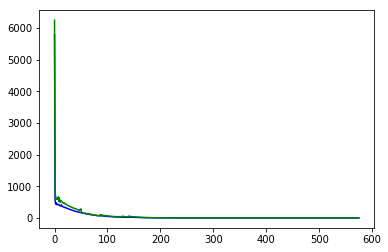

In [25]:
plt.plot(train_loss,"b")
plt.plot(test_loss,"g")
plt.show()

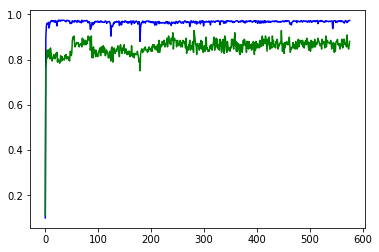

In [26]:
plt.plot(train_acc,"b")
plt.plot(test_acc,"g")
plt.show()